# Produces a file that can be inputed in the IMo
My apologies, the code is not yet well clean and readable, with repeated lines and dirty exceptions.. it is still a work private version (to be cleaned asap)

### Only required downloads: pointing files

* HFT: 20220527_HFT_pointing_matrix.xlsx by Cristian, available on https://wiki.kek.jp/display/cmb/IMo-V1.3+-+June2022
* MFT: 20220804_MFT_pointing_matrix.xlsx by Cristian, available on https://wiki.kek.jp/display/cmb/IMo-V1.3+-+June2022
* LFT: bolometer_database_IMo_LFT.csv by Y. Sakurai, available on https://wiki.kek.jp/display/cmb/IMo-V1.3+-+June2022

### Other docs:
* The orientation specifications list are taken from https://docs.google.com/presentation/d/1RstZ7ahXCZ5q0qni4B-paJjjexNn8Xj--qKQPj5J6No/edit#slide=id.g1433b67e216_0_0, 
* The squids from some presentation aswell, that is quoted in wikiv2.0.
* The 1/f thermal bath parameters are taken from the wiki v2.0 in consistence with Tijmen note and Francesco inputs.
* The beams are provided by Cristian (HFT, MFT) or by the LFT team (LFT).

### summary
* 1) Pointings, quaternions and others
* 2) Checkpoint : plot_lb
* 3) Squids
* 4) 1/f thermal bath
* 5) Beams
* 6) Bandpasses
* 7) Save


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option("display.precision", 5)
from scipy.spatial.transform import Rotation
from matplotlib.markers import MarkerStyle
import os
from tqdm import tqdm


def define_plot_resolution():
    fig = plt.gcf()
    DPI = fig.get_dpi()
    ax = plt.gca()
    for tickLabel in ax.get_xticklabels()+ax.get_yticklabels(): tickLabel.set_fontsize(26)
    ax.yaxis.label.set_size(26)
    ax.xaxis.label.set_size(26)
    ax.yaxis.offsetText.set_fontsize(26)
    ax.xaxis.offsetText.set_fontsize(26)



/home/weymann-l/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/weymann-l/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/weymann-l/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1) Pointings, quaternions and others

In [2]:
def get_quaternion(theta, phi, psi):
    
    quat_posi = np.array([np.sin(np.deg2rad(phi))*np.sin(np.deg2rad(theta/2)),
                          -np.cos(np.deg2rad(phi))*np.sin(np.deg2rad(theta/2)),
                          0,
                          np.cos(np.deg2rad(theta/2))])
    
    quat_orient = np.array([0,
                            0,
                            np.sin(np.deg2rad(psi/2)),
                            np.cos(np.deg2rad(psi/2))])
    
    return (Rotation.from_quat(quat_posi) * Rotation.from_quat(quat_orient)).as_quat()

       
def plot_position(list_wafer):
    
    plt.figure(figsize = (8,8))
    for i, wafer_pf in enumerate(list_wafer):
        
        plt.scatter(wafer_pf["u"],
                    wafer_pf["v"],
                    label='Wafer '+str(i)+' w/ freqs '+str(wafer_pf["f"].unique()),
                    s=90)
        
        cond = np.array([x[-1] for x in wafer_pf['pixel_ID']])
        
        plt.scatter(wafer_pf[cond=='Q']["u"],
                    wafer_pf[cond=='Q']["v"],
                    marker='+',
                    s=70,
                    color='white')
        
        plt.scatter(wafer_pf[cond=='U']["u"],
                    wafer_pf[cond=='U']["v"],
                    marker='x',
                    s=70,
                    color='white')

    plt.xlabel(r'$u$', fontsize=16)
    plt.ylabel(r'$v$', fontsize=16)
    
    plt.legend()
    plt.show()

### HFT


In [3]:
def for_a_HFT_wafer(wafer_pf):

    # convert u, v into euler angles
    wafer_pf["roll"] = np.rad2deg(np.arcsin(np.sqrt((wafer_pf["u"]/1000)**2 + (wafer_pf["v"]/1000)**2)))
    wafer_pf["pitch"] = np.rad2deg(np.arctan2(wafer_pf["v"], wafer_pf["u"])) 
    
    yaw_list, pf_quat = [], []
    
    # convert polar into euler angle
    for i in range(len(wafer_pf['pixel_ID'])):

        if wafer_pf.iloc[i]['pol'][-1]=='T':
            yaw = 0
        elif wafer_pf.iloc[i]['pol'][-1]=='B':
            yaw = 90
        if wafer_pf.iloc[i]['pixel_ID'][-1]=='Q':
            yaw += 0
        elif wafer_pf.iloc[i]['pixel_ID'][-1]=='U':
            yaw += 45
        yaw_list.append(yaw)        
        
        quat = get_quaternion(wafer_pf.iloc[i]['roll'],
                              wafer_pf.iloc[i]['pitch'],
                              yaw,)
        pf_quat.append(quat)
        
    pf_quat = np.transpose(pf_quat)
    
    # fill in the columns
    wafer_pf["yaw"]=yaw_list
    wafer_pf["qx"], wafer_pf["qy"], wafer_pf["qz"], wafer_pf["qw"]=pf_quat[0], pf_quat[1], pf_quat[2], pf_quat[3]
    return wafer_pf


def return_quat(pf):
    """ 
    input: list of df containing the pointing files of Cristian
    output: same list but with 8 more columns in the df ; pol, 3 angles, quaternions
    """
    new_pf = []
    frequencies_in_wafers = [[195,280], [235,337], [402]] # HFT 2
    
    for j, wafer_pf in enumerate(pf):
        
        # duplicate the lines to let B and T polarizations be represented in a new column
        wafer_pfpol_all = []

        wafer_pf['u'], wafer_pf['v']=1000*wafer_pf['u'], 1000*wafer_pf['v'] #go in mm

        for pol in ['B','T']:
            spol = pd.DataFrame({'pol':len(wafer_pf)*[pol]})
            wafer_pfpol = pd.concat([wafer_pf,spol],axis=1)
            wafer_pfpol_all.append(wafer_pfpol)
        wafer_pf = pd.concat(wafer_pfpol_all, axis=0, ignore_index=True)

        # duplicate the lines to let frequencies be represented in a new column
        wafer_pff_all = []
        for f in frequencies_in_wafers[j]:
            sf = pd.DataFrame({'f':len(wafer_pf)*[f]})
            wafer_pff = pd.concat([wafer_pf, sf], axis = 1)
            wafer_pff_all.append(wafer_pff)
        wafer_pf = pd.concat(wafer_pff_all, axis=0, ignore_index=True)
            
        # fill 7 more columns with the 3 angles and the quaternions
        wafer_pf = for_a_HFT_wafer(wafer_pf)
        
        wafer_pf.sort_values(by = 'pixel_ID') # marche pas ??
        new_pf.append(wafer_pf)
    
    return new_pf

def modify_to_give_LFTlike_pf_HFT(list_pf):
    
    list_pf_new = []
    
    for pf in list_pf:
        new_names = []
        n = len(pf.pixel_ID)

        for i in range(n):
            pfi = pf.iloc[i]
            pixel_ID = pfi.pixel_ID
            freq = str(pfi['f'])
            _0freq = (3-len(freq))*'0'+freq
            pol = pfi['pol']
            #print(pixel_ID, freq, pol)
            new_name = pixel_ID+'_'+ _0freq+'_'+pol
            new_names.append(new_name)

        pf['boloName'] = new_names
        pf = pf.assign(pixel_ID=pf['boloName'])
        pf = pf.rename(columns = {'boloName' : 'todel', 'pixel_ID' : 'boloName', 'u' : 'x[mm]', 'v' : 'y[mm]', 'roll' : 'theta[deg.]', 'pitch' : 'phi[deg.]', 'yaw' : 'pol.ang.[deg.]'})
        pf.drop(['todel', 'pol', 'f'], inplace=True, axis=1)
        pf['diameter[mm]']=6.6
        
        for i in range(n):
            if pf['boloName'].iloc[i][6]=='2':pf['diameter[mm]'].iloc[i]=5.7
                
        list_pf_new.append(pf)

    pf = pd.concat(list_pf_new, axis=0, ignore_index=True)
    pf = pf.reindex(columns=['boloName','x[mm]','y[mm]','diameter[mm]','theta[deg.]','phi[deg.]', 'pol.ang.[deg.]', 'qx', 'qy', 'qz', 'qw'])

    return pf


In [4]:
hft_pf = []
for i in range(3):
    a = pd.read_excel("20220527_HFT_pointing_matrix.xlsx", 
                        skiprows=2, 
                        usecols = range(i*3+1,(i+1)*3+1), 
                        names = ['pixel_ID', 'u', 'v'])
    hft_pf.append(a[a['pixel_ID'].notna()])

list_df = return_quat(hft_pf);

harmonious_form = modify_to_give_LFTlike_pf_HFT(list_df)
print('\n\nFile header:\n', harmonious_form.iloc[[*np.random.randint(0, len(harmonious_form), size=4)]])
print('\n\nNumber of bolos:\n'+ str(len(harmonious_form)))

HFT = harmonious_form




File header:
                  boloName      x[mm]      y[mm]  diameter[mm]  theta[deg.]  \
283   002_000_029_U_280_B  137.12620   58.89953           6.6      8.58292   
1199  002_002_014_Q_402_T  -21.55434   77.75861           5.7      4.62827   
477   002_000_096_Q_280_T   52.85505   28.55157           6.6      3.44404   
1234  002_002_049_U_402_T  -58.27248  124.03924           5.7      7.87691   

      phi[deg.]  pol.ang.[deg.]       qx       qy       qz       qw  
283    23.24487             135 -0.05222 -0.05360  0.92129  0.38161  
1199  105.49313               0  0.03891  0.01079  0.00000  0.99918  
477    28.37731               0  0.01428 -0.02644  0.00000  0.99955  
1234  115.16370              45  0.06861  0.00319  0.38178  0.92170  


Number of bolos:
1354


In [20]:
print(round(1/3, 1))

0.3


### MFT


In [5]:
MFTwaf_det_orient = [75, 15, 60, 60, 15, 75, 30, 15, 15, 60, 60, 30, 75, 30, 60, 15, 15, 60, 30, 75, 30, 
                     75, 60, 60, 15, 15, 75, 30, 75, 30, 0, 15, 60, 60, 15, 30, 75, 30, 45, 0, 0, 45, 45, 
                     30, 75, 0, 0, 45, 45, 0, 75, 0, 45, 45, 0, 0, 45, 45, 0, 0, 45]

MFTwaf_det_handed = ['A', 'B', 'A', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'A', 'A', 'B', 'A', 'B', 'A',
                     'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'B', 'A',
                     'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'B',
                     'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A']

# revising for v2.0 by Cristian

MFTwaf_det_orient = MFTwaf_det_orient[::-1]
MFTwaf_det_handed = MFTwaf_det_handed[::-1]

# new MF2 design is already implemented in "Compute_quat-MFT", ready for a next version

def for_a_MFT_wafer(wafer_pf):

    # convert u, v into euler angles
    wafer_pf["roll"]=np.rad2deg(np.arcsin(np.sqrt((wafer_pf["u"]/1000)**2+(wafer_pf["v"]/1000)**2)))
    wafer_pf["pitch"]=np.rad2deg(np.arctan2(wafer_pf["v"],wafer_pf["u"])) 
    
    yaw_list = []
    pf_quat = []
    
    # convert polar into euler angle
    for i in range(len(wafer_pf['pixel_ID'])):
        

        roll = wafer_pf.iloc[i]['roll']
        pitch = wafer_pf.iloc[i]['pitch']
        if wafer_pf.iloc[i]['pol'][-1]=='T': yaw = 0
        elif wafer_pf.iloc[i]['pol'][-1]=='B': yaw = 90
        yaw += MFTwaf_det_orient[int(wafer_pf.iloc[i]['pixel_ID'][9:11])]
        if MFTwaf_det_handed[int(wafer_pf.iloc[i]['pixel_ID'][9:11])] == 'B': yaw = -yaw
        yaw_list.append(yaw)
                    
        quat = get_quaternion(roll, pitch, yaw)
        pf_quat.append(quat)
    pf_quat=np.transpose(pf_quat)
    
    # fill in the columns
    wafer_pf["yaw"]=yaw_list

    wafer_pf["qx"], wafer_pf["qy"], wafer_pf["qz"], wafer_pf["qw"]=pf_quat[0],pf_quat[1],pf_quat[2],pf_quat[3]
    return wafer_pf


def return_quat_MFT(pf):
    """ 
    input: list of df containing the pointing files of Cristian
    output: same list but with 8 more columns in the df ; pol, 3 angles, quaternions
    """
    new_pf = []
    frequencies_in_wafers = [[119,166], [119,166], [100,140,195], [100,140,195], [100,140,195], [119,166], [119,166]] # MFT
    
    for j, wafer_pf in enumerate(pf):
            
        # duplicate the lines to let B and T polarizations be represented in a new column
        wafer_pfpol_all = []

        wafer_pf['u'], wafer_pf['v']=1000*wafer_pf['u'], 1000*wafer_pf['v'] #go in mm
        wafer_pf['QU_angle'] = MFTwaf_det_orient
        wafer_pf['handed'] = MFTwaf_det_handed
        
        for pol in ['B','T']:
            spol = pd.DataFrame({'pol':len(wafer_pf)*[pol]})
            wafer_pfpol = pd.concat([wafer_pf,spol],axis=1)
            wafer_pfpol_all.append(wafer_pfpol)
        wafer_pf = pd.concat(wafer_pfpol_all, axis=0, ignore_index=True)

        # duplicate the lines to let frequencies be represented in a new column
        wafer_pff_all = []
        for f in frequencies_in_wafers[j]:
            sf = pd.DataFrame({'f':len(wafer_pf)*[f]})
            wafer_pff = pd.concat([wafer_pf, sf], axis = 1)
            wafer_pff_all.append(wafer_pff)
        wafer_pf = pd.concat(wafer_pff_all, axis=0, ignore_index=True)
            
        # fill 7 more columns with the 3 angles and the quaternions
        wafer_pf = for_a_MFT_wafer(wafer_pf)
        
        wafer_pf.sort_values(by = 'pixel_ID')
        new_pf.append(wafer_pf)
    
    return new_pf

def modify_to_give_LFTlike_pf_MFT(list_pf):
    list_pf_new = []
    for pf in list_pf:
        new_names = []
        for i in range(len(pf.pixel_ID)):
            pfi = pf.iloc[i]
            pixel_ID = pfi.pixel_ID
            freq = str(pfi['f'])
            _0freq = (3-len(freq))*'0'+freq
            pol = pfi['pol']
            if len(str(pfi['QU_angle']))==1: new_name = pixel_ID+'_0'+str(pfi['QU_angle'])+pfi['handed']+'_'+ _0freq+'_'+pol
            else: new_name = pixel_ID+'_'+str(pfi['QU_angle'])+pfi['handed']+'_'+ _0freq+'_'+pol
            new_names.append(new_name)
        pf['boloName'] = new_names
        pf = pf.assign(pixel_ID=pf['boloName'])
        pf = pf.rename(columns = {'boloName' : 'todel', 'pixel_ID' : 'boloName', 'u' : 'x[mm]', 'v' : 'y[mm]', 'roll' : 'theta[deg.]', 'pitch' : 'phi[deg.]', 'yaw' : 'pol.ang.[deg.]'})
        pf.drop(['todel', 'pol', 'f'], inplace=True, axis=1)
        pf['diameter[mm]'] = 12
        list_pf_new.append(pf)

    pf = pd.concat(list_pf_new, axis=0, ignore_index=True)
    pf = pf.reindex(columns=['boloName','x[mm]','y[mm]','diameter[mm]','theta[deg.]','phi[deg.]', 'pol.ang.[deg.]', 'qx', 'qy', 'qz', 'qw'])

    return pf


In [6]:
mft_pf = [pd.read_excel("20220804_MFT_pointing_matrix.xlsx", 
                        skiprows=2, 
                        usecols = range(i*3+1,(i+1)*3+1), 
                        names = ['pixel_ID', 'u', 'v']) for i in range(7)]

list_df = return_quat_MFT(mft_pf);
harmonious_form = modify_to_give_LFTlike_pf_MFT(list_df)

print('\n\nFile header:\n', harmonious_form.iloc[[*np.random.randint(0, len(harmonious_form), size=4)]])
print('\n\nNumber of bolos:\n'+ str(len(harmonious_form)))

print('\n\nWafer centers for MF:')
rem = 0
for i in range(9):
    for j in range(len(harmonious_form)):
        lines = harmonious_form.iloc[j]
        if (lines.boloName[9:11]=='30') & (lines.boloName[6]==str(i)) & (lines.boloName[6]!=rem):
            print('W' + str(i) + ':\t'+ str(round(lines['x[mm]'], 2)) +'\t'+ str(round(lines['y[mm]'], 2)))
            rem = lines.boloName[6]

MFT = harmonious_form




File header:
                    boloName      x[mm]      y[mm]  diameter[mm]  theta[deg.]  \
1824  001_005_055_75B_166_T -122.22014  -86.75308            12      8.61994   
856   001_003_002_00A_100_B   61.82510    0.00000            12      3.54458   
641   001_002_031_30A_140_B   75.85131 -113.52413            12      7.84725   
6     001_000_006_00A_119_B  198.07145  -26.77105            12     11.52950   

      phi[deg.]  pol.ang.[deg.]       qx       qy       qz       qw  
1824 -144.63248             -75 -0.07182  0.02214 -0.60704  0.79111  
856     0.00000              90 -0.02187 -0.02187  0.70677  0.70677  
641   -56.25108             120 -0.06137  0.03027  0.86400  0.49883  
6      -7.69737              90 -0.07990 -0.06087  0.70353  0.70353  


Number of bolos:
2074


Wafer centers for MF:
W0:	151.7	0.0
W1:	75.85	131.37
W2:	75.85	-131.37
W3:	0.0	0.0
W4:	-75.85	131.37
W5:	-75.85	-131.37
W6:	-151.7	0.0


### LFT


In [7]:
def plot_position_LFT(pf):
    
    plt.figure(figsize = (8,8))
    for i in pf["waferID"].unique():
        pf_waferi = pf[pf["waferID"]==i]
        
        plt.scatter(pf_waferi["x[mm]"],
                    pf_waferi["y[mm]"],
                    label='Wafer '+str(i)+' w/ freqs '+str(pf_waferi["freq[GHz]"].unique()),
                    s=10*pf_waferi["diameter[mm]"])
        
        cond = np.array([x[0] for x in pf_waferi['antenna']])
        
        plt.scatter(pf_waferi[cond=='Q']["x[mm]"],
                    pf_waferi[cond=='Q']["y[mm]"],
                    marker='+',
                    s = 10*pf_waferi[cond=='Q']["diameter[mm]"],
                    color='white')
        
        plt.scatter(pf_waferi[cond=='U']["x[mm]"],
                    pf_waferi[cond=='U']["y[mm]"],
                    marker='x',
                    s = 10*pf_waferi[cond=='U']["diameter[mm]"],
                    color='white')

    plt.xlabel(r'$u$', fontsize=16)
    plt.ylabel(r'$v$', fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def return_quat_LFT(pf):
    """ 
    input: df containing the pointing files of Yuki
    output: same list but with 4 more columns in the df ; pol, 3 angles, quaternions
    """
    pf_quat = []
    for i in range(len(pf['boloName'])):
        
        # if handed B, change the sign of pol.ang.
        if pf['boloName'].iloc[i][13] == 'B': pf['pol.ang.[deg.]'].iloc[i]  = - pf['pol.ang.[deg.]'].iloc[i] 

        quat = get_quaternion(pf.iloc[i]['theta[deg.]'], pf.iloc[i]['phi[deg.]'], pf.iloc[i]['pol.ang.[deg.]'])
        pf_quat.append(quat)
    pf_quat = np.transpose(pf_quat)
    pf['qx'], pf['qy'], pf['qz'], pf['qw'] = pf_quat[0], pf_quat[1], pf_quat[2], pf_quat[3]
    
    return pf



In [8]:
lft_pf = pd.read_csv("bolometer_database_IMo_LFT.csv")
#plot_position_LFT(lft_pf)

pf_with_quat = return_quat_LFT(lft_pf)
pf_with_quat_like_HFT = pf_with_quat.copy()
pf_with_quat_like_HFT.drop(['waferID', 'pixelID', 'antenna'], inplace = True, axis=1)
pf_with_quat_like_HFT = pf_with_quat_like_HFT.reindex(columns=['boloName', 'x[mm]', 'y[mm]', 'diameter[mm]',
                                                               'theta[deg.]','phi[deg.]', 'pol.ang.[deg.]',
                                                               'qx', 'qy', 'qz', 'qw'])

############### revising for v2.0 by Tommaso ###############
#x, y = [], []
for waf, numb in zip(range(4, 9), [8, 35, 35, 8]):
    wafer = pf_with_quat_like_HFT[pf_with_quat_like_HFT['boloName'].astype(str).str[4:7].astype(int)==waf]
    boloName2invert = numb - wafer['boloName'].astype(str).str[8:11].astype(int)
    boloName2invert = boloName2invert.astype(str)
    for a, b in boloName2invert.items():
        b = b.zfill(3)
        boloName2invert[a] = b
    #x+=[i for i in wafer['boloName']]
    wafer['boloName'] =  wafer['boloName'].astype(str).str[:8]+boloName2invert+wafer['boloName'].astype(str).str[11:]
    #y+=[i for i in wafer['boloName']]
    
    pf_with_quat_like_HFT.loc[pf_with_quat_like_HFT['boloName'].astype(str).str[4:7].astype(int)==waf, 'boloName'] = wafer['boloName']
############### revising for v2.0 by Tommaso ###############

#correspondance_old_new = {i:j for i,j in zip(x,y)}

print('\n\nFile header:\n', pf_with_quat_like_HFT.iloc[[*np.random.randint(0, len(pf_with_quat_like_HFT), size=4)]])
print('\n\nNumber of bolos:\n'+ str(len(pf_with_quat_like_HFT)))
LFT = pf_with_quat_like_HFT#.to_excel('LFT_pf_wquat.xlsx')





File header:
                  boloName    x[mm]   y[mm]  diameter[mm]  theta[deg.]  \
504  000_003_003_UB_040_T  100.881  45.762          32.0         6.36   
312  000_002_007_UB_078_T   22.985  65.123          16.0         3.96   
138  000_001_014_UA_078_T  -48.467  51.612          16.0         4.06   
298  000_002_004_QA_140_T   61.300  79.027          16.0         5.74   

     phi[deg.]  pol.ang.[deg.]       qx       qy       qz       qw  
504      24.40             -45  0.04050 -0.03790 -0.38209  0.92246  
312      70.56             -45  0.03450  0.00184 -0.38245  0.92333  
138     133.20              45  0.03314  0.01252  0.38244  0.92330  
298      52.20               0  0.03956 -0.03069  0.00000  0.99875  


Number of bolos:
1080


### Homogeneize the notations in the output file

In [9]:
LMHFT = pd.concat([LFT, MFT, HFT])

LMHFT = LMHFT.rename(columns = {'boloName' : 'detectors'})
def wafer_(x):
    y=x['detectors']
    if y[2] == '0': return 'L'+'0'+y[6]
    elif y[2] == '1': return 'M'+'0'+y[6]
    elif y[2] == '2': return 'H'+'0'+y[6]
LMHFT['wafer'] = LMHFT.apply(wafer_, axis=1)
LMHFT['pixel'] = LMHFT.apply(lambda x:x['detectors'][8:11], axis=1)
LMHFT['pol'] = LMHFT.apply(lambda x:x['detectors'][-1], axis=1)
def handed_func(x):
    if x['detectors'][2]=='2': return '-'
    else: return x['detectors'][-7]
LMHFT['handed'] = LMHFT.apply(handed_func, axis=1)
def orient_func(x):
    if x['detectors'][2]=='1': return x['detectors'][12:14]
    else: return x['detectors'][12]
LMHFT['orient'] = LMHFT.apply(orient_func, axis=1)



def do_band(x):
    y=x['wafer']
    z=x['pixel']
    if x['wafer'][0]=='M':
        if (x['detectors'][-5:-2]=='100' or x['detectors'][-5:-2]=='140' or x['detectors'][-5:-2]=='195'):
            return x['wafer'][0]+'1'+'-'+x['detectors'][-5:-2]
        else:
            return x['wafer'][0]+'2'+'-'+x['detectors'][-5:-2]
    if (y=='L00' or y=='L03'):
        if (int(z)<3) : return 'L2-'+x['detectors'][-5:-2]
        else : return 'L1-'+x['detectors'][-5:-2]
    elif (y=='L04' or y=='L07'):
        if (int(z)>=3) : return 'L1-'+x['detectors'][-5:-2] # <6 before revising for v2.0 by Tommaso
        else : return 'L2-'+x['detectors'][-5:-2]
    elif (y=='L01' or y=='L02'):
        if (int(z)<18) : return 'L4-'+x['detectors'][-5:-2]
        else : return 'L3-'+x['detectors'][-5:-2]
    elif (y=='L05' or y=='L06'):
        if (int(z)>=18) : return 'L3-'+x['detectors'][-5:-2] # < 18 before revising for v2.0 by Tommaso
        else : return 'L4-'+x['detectors'][-5:-2]
    else:
        return x['wafer'][0]+str(int(x['wafer'][2])+1)+'-'+x['detectors'][-5:-2]
LMHFT['band'] = LMHFT.apply(lambda x:do_band(x), axis=1)
print('Processed channels:\n', LMHFT['band'].unique())
# u,v actually has more sense than x,y since it is about projections on the sky
LMHFT['u'], LMHFT['v'] = LMHFT['x[mm]']/1000, LMHFT['y[mm]']/1000
LMHFT.drop(['x[mm]', 'y[mm]'], inplace=True, axis=1)
LMHFT = LMHFT.reindex(columns=['detectors','wafer','pixel','band','pol','handed','orient','qx','qy','qz','qw', 'u', 'v', 'diameter[mm]', 'theta[deg.]','phi[deg.]','pol.ang.[deg.]'])
LMHFT['pixel'] = LMHFT['pixel'].astype(int)
#LMHFT = LMHFT.rename(columns = {'x[mm]' : 'u', 'y[mm]' : 'v'})

# to be replaced by the path to your instrumentdb datafile 

print('\n\nFinal file header:\n', LMHFT.iloc[[*np.random.randint(0, len(LMHFT), size=4)]])
print('\n\nNumber of bolos:\n', len(LMHFT))



Processed channels:
 ['L2-050' 'L2-068' 'L2-089' 'L1-040' 'L1-060' 'L1-078' 'L4-078' 'L4-100'
 'L4-140' 'L3-068' 'L3-089' 'L3-119' 'M2-119' 'M2-166' 'M1-100' 'M1-140'
 'M1-195' 'H1-195' 'H1-280' 'H2-235' 'H2-337' 'H3-402']


Final file header:
                  detectors wafer  pixel    band pol handed orient       qx  \
23   001_000_023_30B_119_B   M00     23  M2-119   B      B     30  0.07936   
989   000_006_006_UA_140_B   L06      6  L4-140   B      A      U -0.04667   
287    002_000_033_U_280_B   H00     33  H1-280   B      -      U -0.04063   
545   000_004_008_UA_078_B   L04      8  L1-078   B      A      U  0.06768   

          qy       qz       qw        u        v  diameter[mm]  theta[deg.]  \
23  -0.03031 -0.86289  0.49819  0.16716  0.02677          12.0      9.74649   
989  0.01500  0.92277  0.38222  0.07467 -0.06337          16.0      5.62000   
287 -0.08183  0.92002  0.38108  0.13713  0.11960           6.6     10.48350   
545  0.03614  0.92116  0.38156 -0.15226 -0.01493

### Cross-check the position

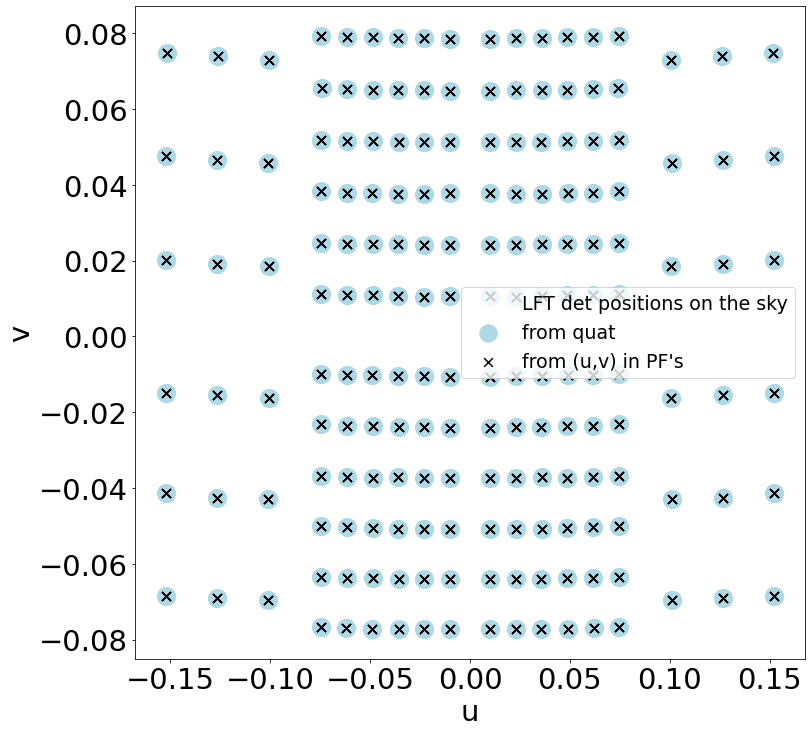

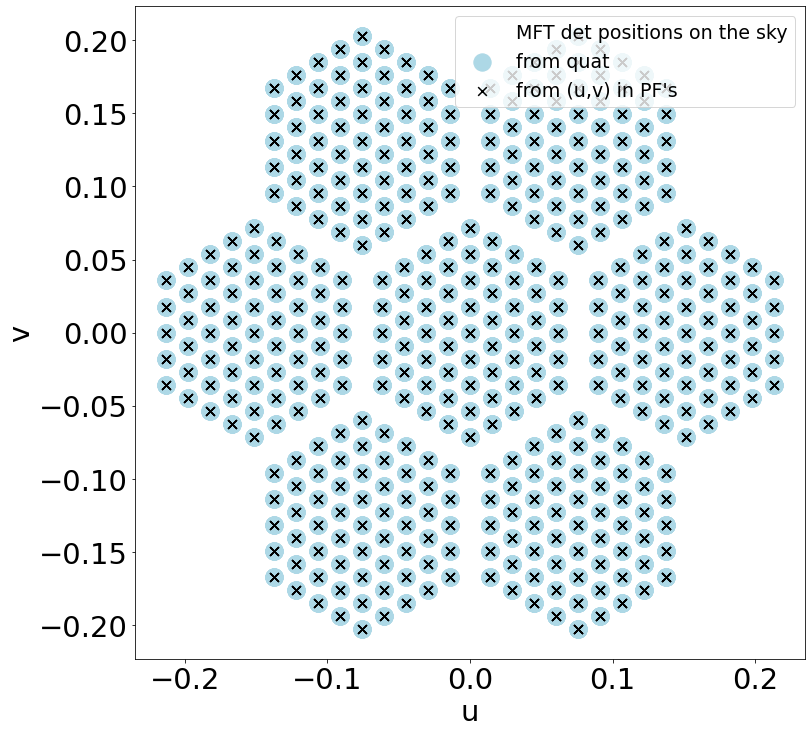

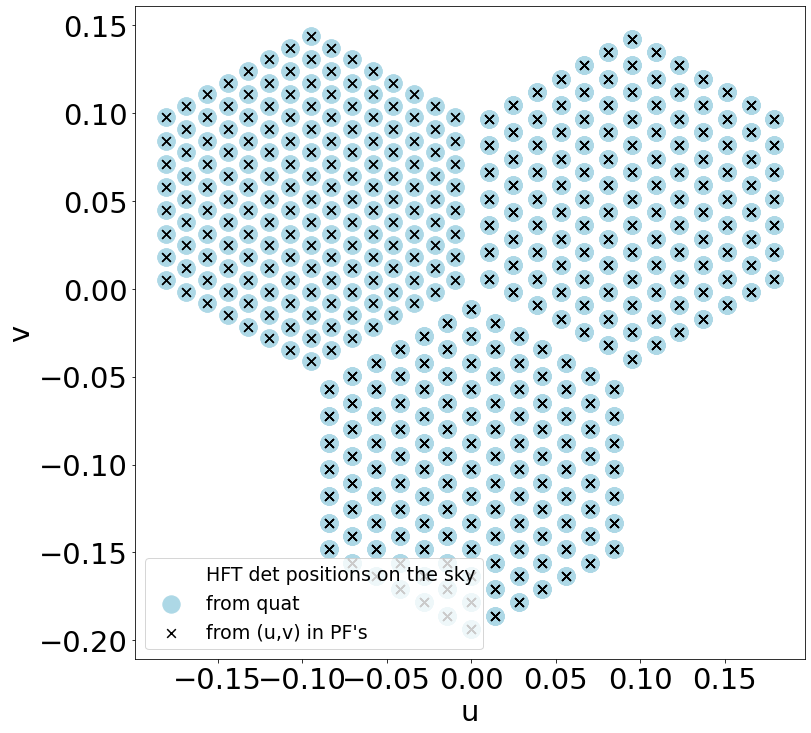

In [10]:
def define_plot_resolution():
    fig = plt.gcf()  

    DPI = fig.get_dpi()
    fig.set_size_inches(12,12)
    ax = plt.gca()
    for tickLabel in ax.get_xticklabels()+ax.get_yticklabels():
        tickLabel.set_fontsize(29)
    ax.yaxis.label.set_size(29)
    ax.xaxis.label.set_size(29)
    ax.yaxis.offsetText.set_fontsize(29)
    ax.xaxis.offsetText.set_fontsize(29)
    return



def pos(quat):
    r = Rotation.from_quat(quat)
    Rb = Rotation.from_quat(np.array([0, 0, 1, 0])) # z
    q = (r * Rb * r.inv()).as_quat()
    return q



for i, inst in enumerate(['L', 'M', 'H']):
    plt.figure(figsize=(10,10))
    mask = LMHFT["wafer"].str.contains(inst)
    instr = LMHFT[mask]
    quat = [instr['qx'], instr['qy'], instr['qz'], instr['qw']]
    posi = np.transpose(pos(np.transpose(quat)))
    plt.plot([],[], label=inst+'FT det positions on the sky', alpha=0)
    plt.scatter(posi[0], posi[1], c='lightblue', s=300, label='from quat')#posi[2]*1000
    #cbar = plt.colorbar()
    #cbar.set_label('z')
    plt.scatter(instr['u'].tolist(),instr['v'].tolist(),marker = 'x', s=75,color='k',label="from (u,v) in PF's")

    plt.xlabel("u")
    plt.ylabel("v")

    plt.legend(fontsize=19)
    define_plot_resolution()


### Cross check the orientation

In [11]:
for i in range(len(LMHFT)):
    yaw = 0
    if LMHFT.iloc[i]['pol'] == 'B': yaw = 90
    if LMHFT.iloc[i]['orient'] == 'U': yaw += 45
    elif LMHFT.iloc[i]['orient'] == 'Q': pass
    else : yaw += int(LMHFT.iloc[i]['orient'])
    if LMHFT.iloc[i]['handed'] == 'B': yaw = -yaw
    n = 0
    if yaw != LMHFT.iloc[i]['pol.ang.[deg.]']:
        print(LMHFT.iloc[i]['detectors'] +' is bugged.')
        n+=1
print('There are '+str(n)+' orient bugs.')

There are 0 orient bugs.


# 2) Checkpoint : plot LB

In [12]:
def third_marker(x0, y0, sx, sy, c):   
    n_marker = 10
    theta = np.zeros((3, n_marker))
    for j in range(3):
        theta[j, :] = np.linspace(float(j)/(3/2)*np.pi, float(j+1)/(3/2)*np.pi, n_marker)
        x = x0 + np.append(0, sx*np.cos(-np.pi/3+theta[j]))
        y = y0 + np.append(0, sy*np.sin(-np.pi/3+theta[j]))
        plt.fill(x, y, color=c[j])
        
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
def define_plot_resolution():
    fig = plt.gcf()
    DPI = fig.get_dpi()
    ax = plt.gca()
    for tickLabel in ax.get_xticklabels()+ax.get_yticklabels(): tickLabel.set_fontsize(26)
    ax.yaxis.label.set_size(26)
    ax.xaxis.label.set_size(26)
    ax.yaxis.offsetText.set_fontsize(26)
    ax.xaxis.offsetText.set_fontsize(26)
def plot_LB(LMHFT, which_rep = 0, plot_waf = True, plot_orient = True, plot_squid = False, plot_pixtype = True, plot_hand = True, plot_number = True, save_plots=True, legend = True):
    
    """
    LMHFT:       instrument to plot
    which_rep:   0 -> Default, pixel projections on the sky, basically in the xlsx ("true" unitless u, v coordinates)
                 1 -> Focal plane seen from below ("fake" coordinates to be able to compare with properly focal plane drawings)
                 2 -> Focal plane seen from above ("fake" coordinates)
    plot_waf:    True -> color the pixel according to the wafer it belongs to. If plot_pixtype or plot_squid are True, overtext the # wafer instead.
    plot_orient: True -> draw the antenna orientation (could be complemented with some arrows for the handiness)
    plot_number: True -> write the # pixel
    plot_squid:  True -> color the pixel according to the squid (in the wafer) it belongs to (Default = False)
    plot_pixtype:True -> color the pixel according to its pixtype
    plot_hand:   True -> color the antenna according to its handiness (A=white / B=yellow)
    save_plots:  True -> save the plots with appropriate name

    """
    
    LMHFT = LMHFT.copy(deep=True)
    
    figsize = lambda sc : (14, 14/sc)

    if which_rep == 0:
        title_add = 'pointings on the sky'
        orient_fac = 1
    elif which_rep == 1:
        title_add = 'view from the FPU to the sky'
        orient_fac = 1
        # take the opposite of MHFT vertical coordinate because of inversion in optical path
        LMHFT.loc[(LMHFT['wafer'].astype(str).str[0] != 'L'), "v"] = -LMHFT.loc[(LMHFT['wafer'].astype(str).str[0] != 'L'), "v"]
    elif which_rep == 2: # Not sure about that, not sure aswell if we care
        title_add = 'view from the sky to the FPU'
        orient_fac = 1
        LMHFT.loc[(LMHFT['wafer'].astype(str).str[0] != 'L'), "v"] = -LMHFT.loc[(LMHFT['wafer'].astype(str).str[0] != 'L'), "v"]
        LMHFT["u"] = -LMHFT["u"]
        orient_fac = -1

    for i in ['L', 'M', 'H']:
        iFT = LMHFT[LMHFT['wafer'].astype(str).str[0] == i]

        sc = (max(iFT['u'])-min(iFT['u']))/(max(iFT['v'])-min(iFT['v']))
        sc_r = 1*((i=='H')*0.38+(i=='L')*1+(i=='M')*0.75) # Y a mieux à faire
        s = lambda r : np.pi*(r/sc_r)**2

        plt.figure(figsize=figsize(sc))
        plt.title(i+'FT'+' '+title_add, fontsize = 24)
        
        if plot_pixtype:
            if plot_squid: raise TypeError("You have to chose between plotting pixtypes or squids!") 
            for w, c in zip(iFT['band'].astype(str).str[:2].drop_duplicates().astype(str).str[1].sort_values(), colors):
                iwFT = iFT[iFT['band'].astype(str).str[:2] == i+w]
                plt.scatter(iwFT['u'], iwFT['v'], color = c, s = s(iwFT['diameter[mm]']), label = str(i+w)+': '+str([int(x) for x in iwFT["band"].astype(str).str[-3:].unique()]),)

        if plot_waf:
            for w, c in zip(iFT['wafer'].astype(str).str[-1].drop_duplicates(), colors):
                iwFT = iFT[iFT['wafer'].astype(str).str[-1] == w]
                if plot_pixtype or plot_squid: plt.text(np.mean(iwFT['u']),np.mean(iwFT['v']),'W'+w, size = 60, weight = 'bold', alpha = 0.7, horizontalalignment='center', verticalalignment='center', color = 'lightgray', )
                else: plt.scatter(iwFT['u'], iwFT['v'], color = c, s = s(iwFT['diameter[mm]']), label = str(w)+': '+str([int(x) for x in iwFT["band"].astype(str).str[-3:].unique()]),)

        if plot_squid:
            if 'squid' not in iFT.keys(): raise TypeError("Specify the squids in the input xsl or put plot_squid to False") 
            for sq, c in zip(iFT['squid'].astype(str).str[-1].drop_duplicates().sort_values(), colors):
                iwFT = iFT[iFT['squid'].astype(str).str[-1] == sq]
                plt.scatter(iwFT['u'], iwFT['v'], color = c, s = s(iwFT['diameter[mm]']), label = str(sq))
            # central pixels of MFT
            if i == 'M':
#                plt.scatter(iFT.loc[(iFT['band'].astype(str).str[:2]=='M2') & (iFT['pixel'] == 30), 'u'], iFT.loc[(iFT['band'].astype(str).str[:2]=='M2') & (iFT['pixel'] == 30), 'v'], s = s(iFT.loc[(iFT['band'].astype(str).str[:2]=='M2') & (iFT['pixel'] == 30), 'diameter[mm]']), color = colors[2], marker=MarkerStyle('o', fillstyle='left'))
#                plt.scatter(iFT.loc[(iFT['band'].astype(str).str[:2]=='M2') & (iFT['pixel'] == 30), 'u'], iFT.loc[(iFT['band'].astype(str).str[:2]=='M2') & (iFT['pixel'] == 30), 'v'], s = s(iFT.loc[(iFT['band'].astype(str).str[:2]=='M2') & (iFT['pixel'] == 30), 'diameter[mm]']), color = colors[4], marker=MarkerStyle('o', fillstyle='right'))
                for iFT30u, iFT30v in zip(iFT.loc[(iFT['band'].astype(str).str[:2]=='M1') & (iFT['pixel'] == 30), 'u'].drop_duplicates(), iFT.loc[(iFT['band'].astype(str).str[:2]=='M1') & (iFT['pixel'] == 30), 'v'].drop_duplicates()):
                    third_marker(iFT30u, iFT30v, 0.009, 0.009, [colors[5], colors[3], colors[1]])
        
        if plot_number:
            for u, v, pixel in zip(iFT['u'], iFT['v'], iFT['pixel']): 
                plt.text(u, v, pixel, size=10, color='k',horizontalalignment='center',verticalalignment='center')
        
        if plot_orient:
            for orient in iFT['orient'].drop_duplicates():
                iwFT = iFT[iFT['orient'] == orient]
                if plot_hand: c = (iwFT['handed']=='B').astype(int).apply(lambda x: x*'yellow'+(1-x)*'white')
                else: c = 'white'
                if orient =='Q' or orient =='U': orient = int((orient=='Q')*0+(orient=='U')*45)
                orient = orient_fac * int(orient)
                plt.scatter(iwFT['u'], iwFT['v'], marker = (1, 1, -orient), color = c, s = s(iwFT['diameter[mm]']), zorder=2)
                plt.scatter(iwFT['u'], iwFT['v'], marker = (1, 1, -orient+90), color = c, s = s(iwFT['diameter[mm]']), zorder=2)
        
        if legend:
            lgnd = plt.legend(fontsize = 12, loc = 'lower right', title=plot_pixtype*"Pixtype: [freqs in GHz]"+(plot_waf and not plot_pixtype and not plot_squid)*"Wafer: [freqs in GHz])"+plot_squid*"Squid (/waf)", title_fontsize = 14)
            for lgndH in lgnd.legendHandles: lgndH._sizes = [100]

        #if which_rep == 0: plt.xlabel('u') ; plt.ylabel('v')
        
        #lgnd2 = plt.legend(, ["A", "B"], fontsize = 12, loc = 'upper left')
        ##for lgndH in lgnd2.legendHandles: lgndH._sizes = [100]
        #plt.gca().add_artist(lgnd2)
        
        define_plot_resolution()
        if save_plots:
            name_pic = i+'FT_'+(which_rep==0)*'pointings'+(which_rep==1)*'below'+(which_rep==2)*'above'+plot_waf*'_waf'+plot_pixtype*'_pixtype'+plot_squid*'_squid'+'.pdf'
            #plt.savefig(name_pic, format='pdf')


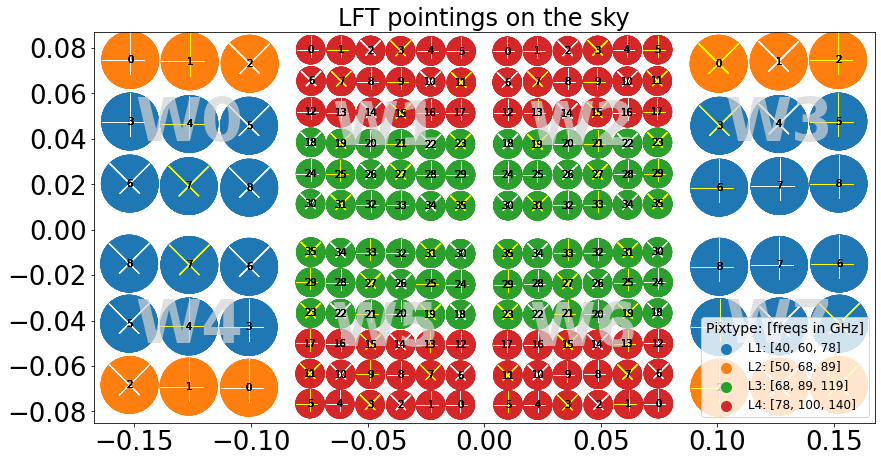

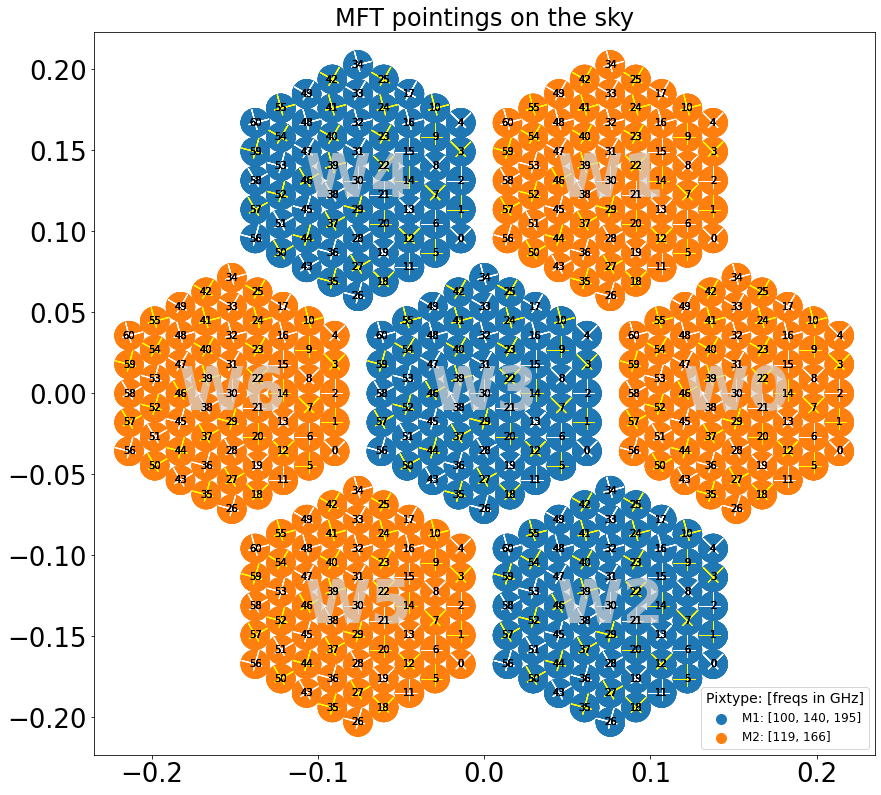

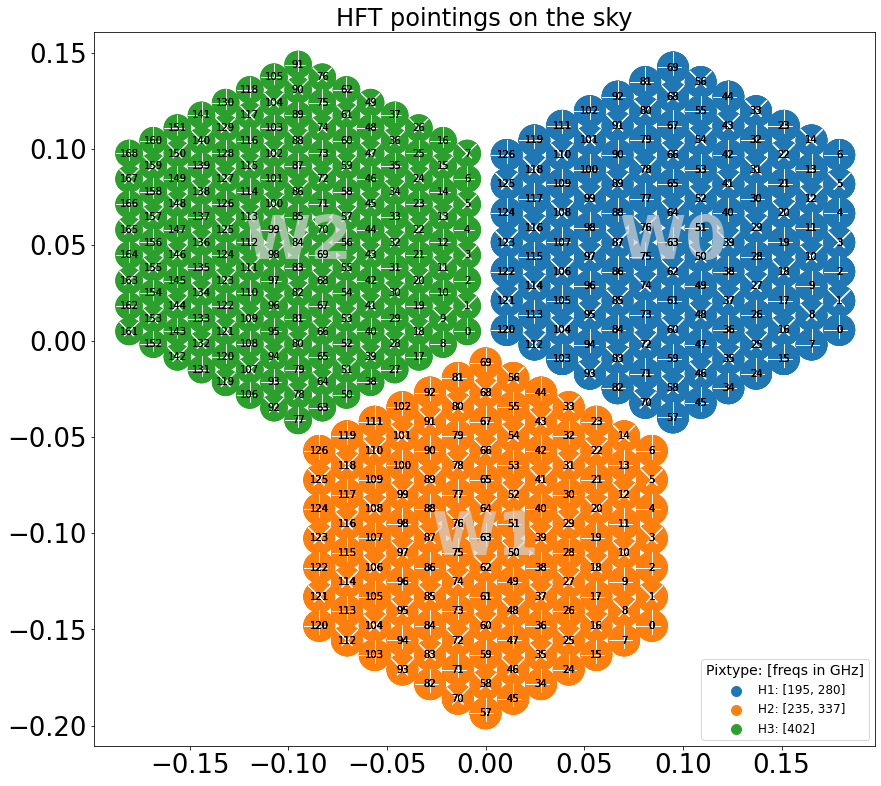

In [13]:
plot_LB(LMHFT, which_rep = 0, plot_waf = True, plot_number = True, plot_orient = True, plot_squid = False, plot_pixtype = True, plot_hand = True)


# 3) add squid

In [14]:
LMHFT['squid'] = 0

#######################################################################
################################# MF1 #################################
#######################################################################

S4 = [1, 7, 14, 22, 31, 30, 2, 8, 15, 23, 32]    #S4
S5 = [3, 9, 16, 24, 33, 4, 10, 17, 25, 34]    #S5
S6 = [38, 39, 40, 41, 42, 45, 46, 47, 48, 49]#30    #S6
S1 = [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]    #S1
S2 = [21, 29, 37, 44, 50, 13, 20, 28, 36, 43]#30    #S2
S3 = [0, 5, 11, 18, 26, 6, 12, 19, 27, 35]    #S3

Squid_MF1 = []
for i in range(61):
    for j, S in enumerate([S1, S2, S3, S4, S5, S6]):
        if i in S: 
            Squid_MF1.append(j)

# Above Squid_MF1 is from Greg. 
# All Greg is consistent. 
# Inconsistency between Cristian & Greg is solved by interverting pix i <-> pix 60-i (see orientation FPU to sky plans of eachother)
# To keep unchanged the pointings & beams from Cristian, one needs to do the inversion on the Greg's side 
# => Perform the inversion for the previous orientation and handiness, and also for the squids given above.
Squid_MF1 = Squid_MF1[::-1]
#Squid_MF1 = (np.array(Squid_MF1)+4)%6


for i in range(61):
    LMHFT.loc[(LMHFT['band'].astype(str).str[:2]=='M1') & (LMHFT['pixel'] == i), 'squid'] = Squid_MF1[i]

# Split the central pixel:
LMHFT.loc[(LMHFT['band']=='M1-100') & (LMHFT['pixel'] == 30), 'squid'] = 1
LMHFT.loc[(LMHFT['band']=='M1-140') & (LMHFT['pixel'] == 30), 'squid'] = 3
LMHFT.loc[(LMHFT['band']=='M1-195') & (LMHFT['pixel'] == 30), 'squid'] = 5

#######################################################################
################################# MF2 #################################
#######################################################################

S1 = [0, 1, 5, 6, 11, 12, 18, 19, 26, 27, 28, 20, 14, 22, 21, 30]
S2 = [25, 17, 10, 4, 24, 16, 9, 3, 15, 8, 2, 13, 7, 37, 29]
S3 = [46, 53, 59, 34, 42, 49, 55, 60, 33, 41, 48, 54, 32, 40, 39]
S4 = [23, 31, 47, 38, 45, 52, 58, 35, 36, 43, 44, 50, 51, 56, 57]

Squid_MF2 = []
for i in range(61):
    for j, S in enumerate([S1, S2, S3, S4]):
        if i in S: 
            Squid_MF2.append(j)

for i in range(61):
    LMHFT.loc[(LMHFT['band'].astype(str).str[:2]=='M2') & (LMHFT['pixel'] == i), 'squid'] = Squid_MF2[i]

# Instead:
#for i in range(61):
#    LMHFT.loc[(LMHFT['band'].astype(str).str[:2]=='M2') & (LMHFT['pixel'] == i), 'squid'] = Squid_MF1[i]
#
## Split the central pixel (two frequencies to be splitted among 2 squids... to be fixed):
#LMHFT.loc[(LMHFT['band']=='M1-119') & (LMHFT['pixel'] == 30), 'squid'] = 1
#LMHFT.loc[(LMHFT['band']=='M1-166') & (LMHFT['pixel'] == 30), 'squid'] = 3

#########################################################################
################################# HF1/2 #################################
#########################################################################

S1 = [0, 1, 2, 7, 8, 9, 10, 15, 16, 17, 18, 24, 25, 26, 27, 37,]
S2 = [3, 4, 5, 6, 11, 12, 13, 19, 20, 28, 29, 38, 39, 40, 51, 63]
S3 = [14, 23, 43, 42, 54, 66, 78, 55, 67, 79, 90, 77, 76, 65, 64, 52]
S4 = [33, 44, 56, 69, 68, 81, 80, 92, 91, 32, 22, 21, 31, 30, 41, 53]
S5 = [89, 99, 108, 116, 100, 109, 117, 124, 101, 110, 118, 125, 102, 111, 119, 126]
S6 = [75, 86, 87, 97, 88, 98, 107, 115, 122, 123, 114, 121, 105, 113, 120]
S7 = [36, 47, 59, 71, 48, 60, 72, 83, 49, 61, 73, 50, 62, 74, 103, 112]
S8 = [106, 96, 85, 95, 84, 104, 94, 93, 82, 70, 57, 58, 45, 46, 34, 35]

Squid_HF12 = []
for i in range(127):
    for j, S in enumerate([S1, S2, S3, S4, S5, S6, S7, S8]):
        if i in S: 
            Squid_HF12.append(j)

for i in range(127):
    LMHFT.loc[((LMHFT['band'].astype(str).str[:2]=='H1') | (LMHFT['band'].astype(str).str[:2]=='H2')) & (LMHFT['pixel'] == i), 'squid'] = Squid_HF12[i]

#######################################################################
################################# HF3 #################################
#######################################################################

S1 = [0, 1, 2, 3, 8, 9, 10, 11, 17, 18, 19, 20, 27, 28, 29, 30, 38, 39, 40, 41, 50, 51, 52, 53, 63, 64, 65, 66]
S2 = [4, 5, 6, 7, 12, 13, 14, 15, 21, 22, 23, 24, 31, 32, 33, 34, 42, 43, 44, 45, 54, 55, 56, 57, 67, 68, 69, 70]
S3 = [16, 25, 26, 35, 36, 37, 46, 47, 48, 49, 59, 60, 61, 62, 73, 74, 75, 76, 88, 89, 90, 91, 103, 104, 105, 117, 118, 130]
S4 = [58, 71, 72, 85, 86, 87, 99, 100, 101, 102, 113, 114, 115, 116, 126, 127, 128, 129, 138, 139, 140, 141, 149, 150, 151, 159, 160, 168]
S5 = list(range(131, 138))+list(range(142, 149))+list(range(152, 159))+list(range(161, 168))
S6 = list(range(77, 85))+list(range(92, 99))+list(range(106, 113))+list(range(119, 126))

Squid_HF3 = []
for i in range(169):
    for j, S in enumerate([S1, S2, S3, S4, S5, S6]):
        if i in S: 
            Squid_HF3.append(j)

Stot = S1 + S2 + S3 + S4 + S5 + S6
#print('Length:',(len(Squid_HF3)==169)*'ok'+(len(Squid_HF3)!=169)*str(len(Squid_HF3)), '\nNo double:', ([x for x in Stot if Stot.count(x) > 1]==[])*'ok'+([x for x in Stot if Stot.count(x) > 1]!=[])*str([x for x in Stot if Stot.count(x) > 1]),'\nAll:', ([S for S in range(169) if S not in Stot]==[])*'ok'+([S for S in range(169) if S not in Stot]!=[])*str([S for S in range(169) if S not in Stot]))

for i in range(169):
    LMHFT.loc[(LMHFT['band'].astype(str).str[:2]=='H3') & (LMHFT['pixel'] == i), 'squid'] = Squid_HF3[i]
    
########################################################################
################################# LF12 #################################
########################################################################

#S1 = [2, 5, 7, 8]
#S2 = [0, 1, 3, 4, 6]

S1 = [0, 3, 6, 7]
S2 = [1, 2, 4, 5, 8]

Squid_LF12 = []
for i in range(9):
    for j, S in enumerate([S1, S2]):
        if i in S: 
            Squid_LF12.append(j)

for i in range(9):
    LMHFT.loc[((LMHFT['band'].astype(str).str[:2]=='L1') | (LMHFT['band'].astype(str).str[:2]=='L2')) & (LMHFT['pixel'] == i), 'squid'] = Squid_LF12[i]

########################################################################
################################# LF34 ################################# 
########################################################################

S1 = [0, 6, 7, 12, 13, 18, 19, 24, 30]
S2 = [1, 2, 8, 14, 20, 25, 26, 31, 32]
#S1 = [0, 1, 6, 7, 12, 18, 24, 30, 31]
#S2 = [2, 8, 13, 14, 19, 20, 25, 26, 32]
S3 = np.array(S1)+3
S4 = np.array(S2)+3

Squid_LF34 = []
for i in range(36):
    for j, S in enumerate([S1, S2, S3, S4]):
        if i in S: 
            Squid_LF34.append(j)

for i in range(36):
    LMHFT.loc[((LMHFT['band'].astype(str).str[:2]=='L3') | (LMHFT['band'].astype(str).str[:2]=='L4')) & (LMHFT['pixel'] == i), 'squid'] = Squid_LF34[i]



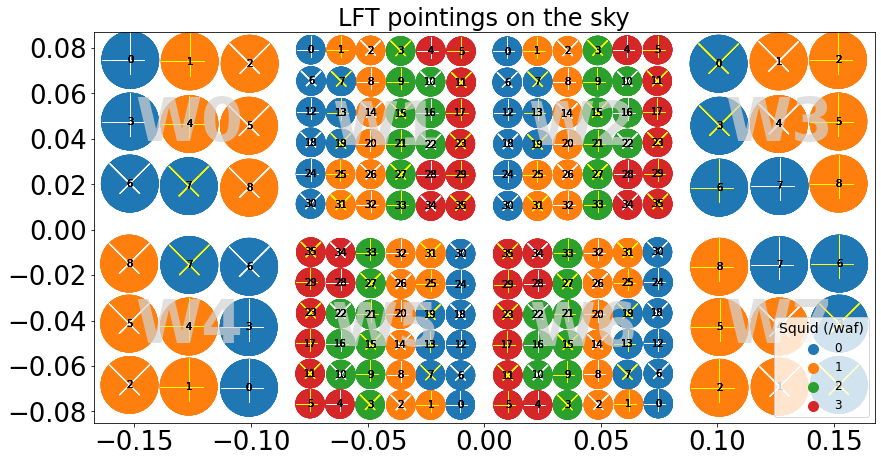

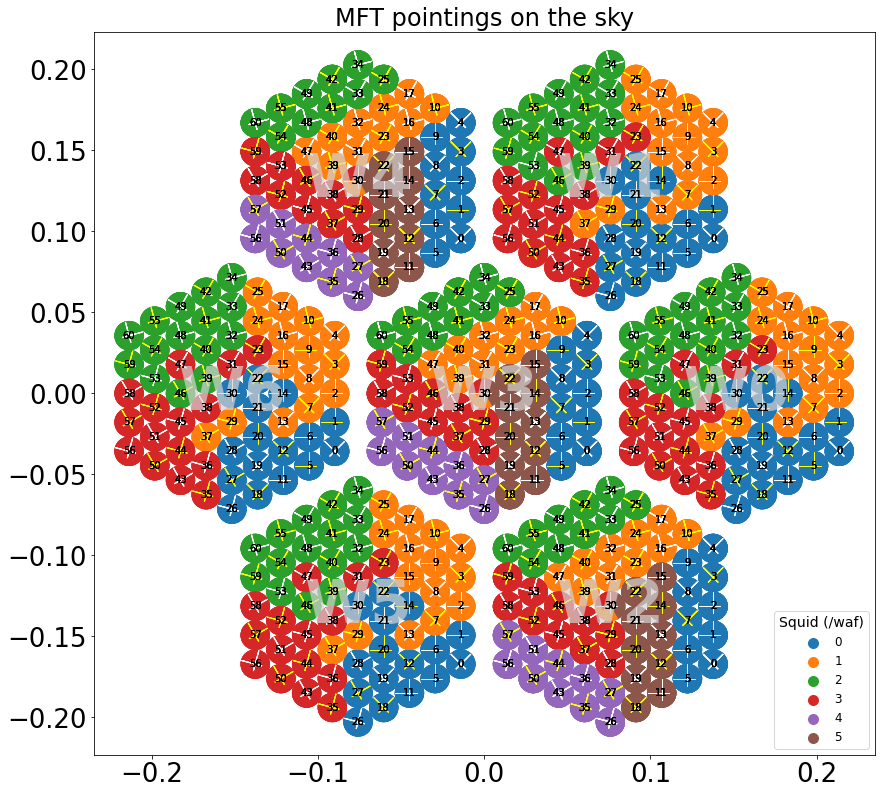

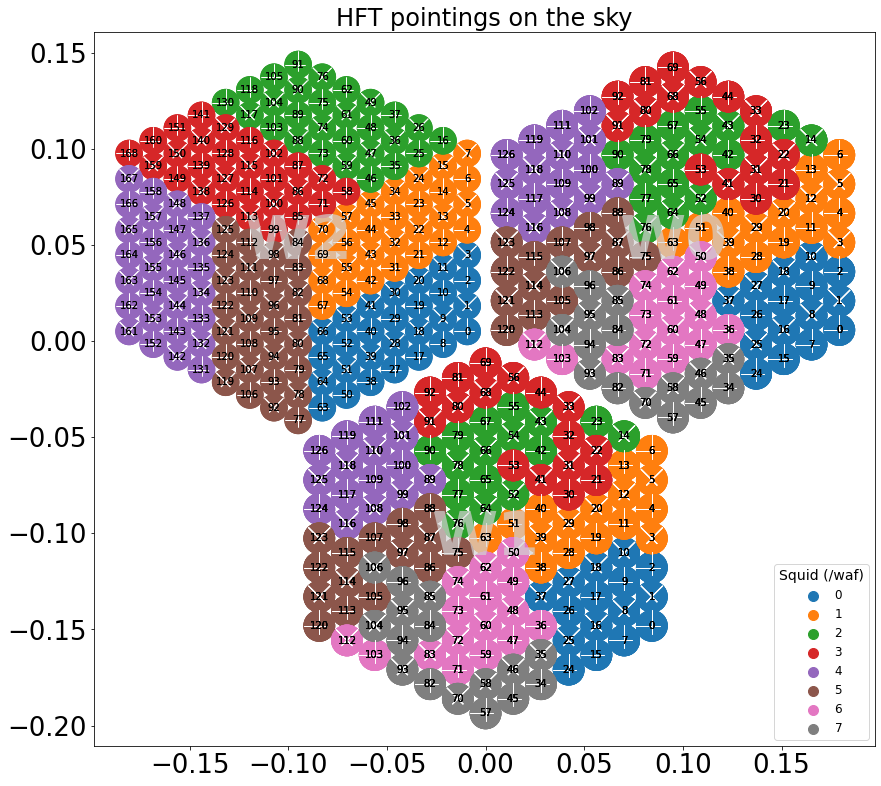

In [15]:
plot_LB(LMHFT, which_rep=0, plot_waf=True, plot_number = True, plot_orient=True, plot_squid = True, plot_hand=True, plot_pixtype=False, legend =True)


# 4) Add thermal bath 1/f noise

In [16]:
LMHFT['psd_thermalbath_corr_uk2'] = 0.
LMHFT['psd_thermalbath_uncorr_uk2'] = 0.
dic = {'L1-040': 117.93560547761395, 'L1-060': 59.064055530954626, 'L1-078': 53.349680964151965, 'L2-050': 75.23437478598525, 'L2-068': 64.21706417000377, 'L2-089': 57.725662533151365, 'L3-068': 106.5479569840322, 'L3-089': 62.13993889234585, 'L3-119': 39.92721803197361, 'L4-078': 81.63477070518171, 'L4-100': 50.349714403812825, 'L4-140': 35.02338076232635, 'M1-100': 70.29154468299386, 'M2-119': 58.39872101570062, 'M1-140': 53.18872860724587, 'M2-166': 49.11713409261268, 'M1-195': 48.87059318389626, 'H1-195': 84.18643126368721, 'H2-235': 72.47299915687462, 'H1-280': 80.65012983273263, 'H2-337': 110.53833707604461, 'H3-402': 212.5009242368588}
for band in LMHFT['band'].unique():
    LMHFT.loc[LMHFT['band'] == band, 'psd_thermalbath_corr_uk2'] = 0.6*(0.3*dic[band])**2*2.4
    LMHFT.loc[LMHFT['band'] == band, 'psd_thermalbath_uncorr_uk2'] = 0.4*(0.3*dic[band])**2*2.4
    print(band, dic[band], (0.3*dic[band])**2*2.4)
    

L2-050 75.23437478598525 1222.605608278628
L2-068 64.21706417000377 890.7475674127062
L2-089 57.725662533151365 719.7664568165154
L1-040 117.93560547761395 3004.3023205042236
L1-060 59.064055530954626 753.5295336449575
L1-078 53.349680964151965 614.7767071389883
L4-078 81.63477070518171 1439.4749302269202
L4-100 50.349714403812825 547.5802479578315
L4-140 35.02338076232635 264.9536352049445
L3-068 106.5479569840322 2452.132901693774
L3-089 62.13993889234585 834.056353197607
L3-119 39.92721803197361 344.34347179091577
M2-119 58.39872101570062 736.6486931142409
M2-166 49.11713409261268 521.0984580778861
M1-100 70.29154468299386 1067.2346708470052
M1-140 53.18872860724587 611.0728237847351
M1-195 48.87059318389626 515.8803336795118
H1-195 84.18643126368721 1530.868725125755
H1-280 80.65012983273263 1404.9597834799122
H2-235 72.47299915687462 1134.5044910671475
H2-337 110.53833707604461 2639.244376124048
H3-402 212.5009242368588 9753.834845128145


# 5) beam

# input beams: 119
# assigned beam: 119 / 2074 = 7 / 61 / 2 of the dets = 7*(3*3+4*2)


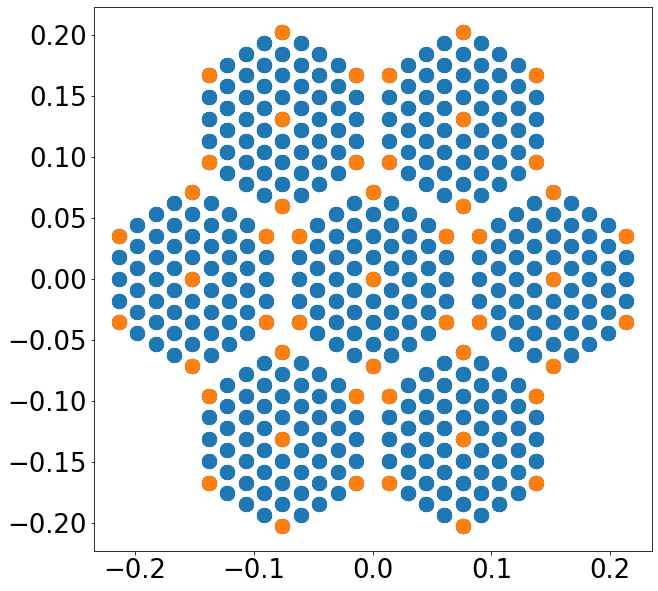

# input beams: 15
# assigned beam: 15 / 1354 = 3*2+3*2


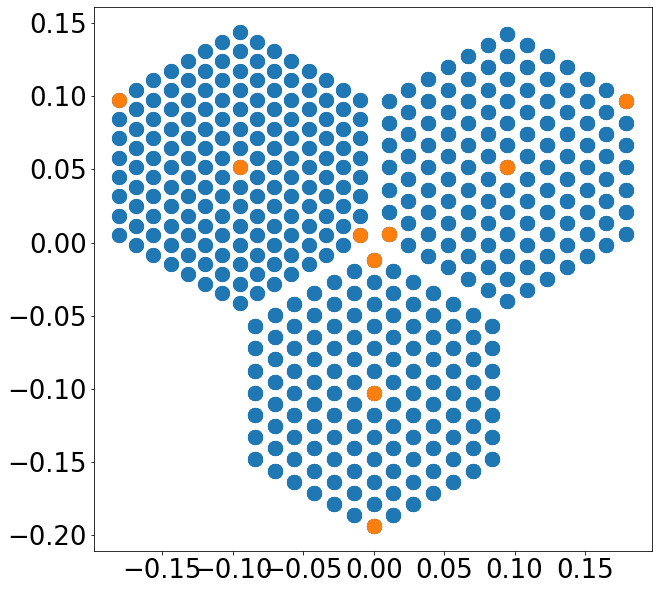

Association beam-det name is less trivial for LFT!


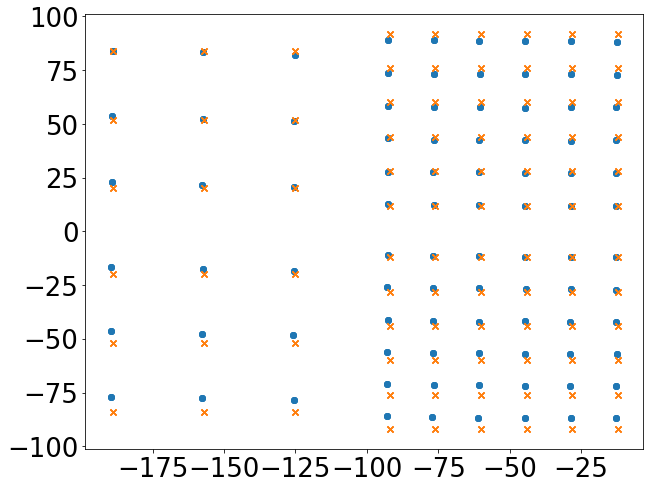

270 / 1080 = 90 * 3 / 1080
1/2 FP * 3/3 freq * 1/2 polarisation = 1/4 detectors


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:04<00:00, 61.19it/s]


In [17]:
LMHFT['beam_file'] = '-'
LMHFT['beam_file_with_vgroove'] = '-'

#######################################################################
################################# MFT #################################
#######################################################################

list_dir = os.listdir('/home/weymann-l/imo/beams/MFT/')
path_beams_MFT = 'IMoV2/Beams/MFT/'
for file in list_dir:
    #print(file)
    LMHFT.loc[(LMHFT['detectors'].astype(str).str[:11]==file[:11]) & (LMHFT['detectors'].astype(str).str[-7:]==file[-11:-4]), 'beam_file'] = path_beams_MFT+file

print("# input beams:",len(list_dir))
print("# assigned beam:",len(LMHFT[(LMHFT['wafer'].astype(str).str[:1]=='M') & (LMHFT['beam_file']!='-')]), '/',len(LMHFT[LMHFT['wafer'].astype(str).str[:1]=='M']), '= 7 / 61 / 2 of the dets = 7*(3*3+4*2)')

plt.figure(figsize = (10,10))
sca2 = LMHFT.loc[LMHFT['wafer'].astype(str).str[:1]=='M', 'u'], LMHFT.loc[LMHFT['wafer'].astype(str).str[:1]=='M', 'v']
plt.scatter(*sca2, s=200)
sca1 = LMHFT.loc[(LMHFT['wafer'].astype(str).str[:1]=='M') & (LMHFT['beam_file']!='-'), 'u'], LMHFT.loc[(LMHFT['wafer'].astype(str).str[:1]=='M') & (LMHFT['beam_file']!='-'), 'v']
plt.scatter(*sca1, s=200)
define_plot_resolution()
plt.show()


#######################################################################
################################# HFT #################################
#######################################################################

list_dir = os.listdir('/home/weymann-l/imo/beams/HFT/baffle/')
path_beams_HFT = 'IMoV2/Beams/HFT/baffle/'
for file in list_dir:
    #print(file)
    LMHFT.loc[(LMHFT['detectors'].astype(str).str[:11]==file[:11]) & (LMHFT['detectors'].astype(str).str[-7:]==file[-11:-4]), 'beam_file'] = path_beams_HFT+file

print("# input beams:",len(list_dir))
print("# assigned beam:",len(LMHFT[(LMHFT['wafer'].astype(str).str[:1]=='H') & (LMHFT['beam_file']!='-')]), '/',len(LMHFT[LMHFT['wafer'].astype(str).str[:1]=='H']), '= 3*2+3*2')


plt.figure(figsize = (10,10))
sca2 = LMHFT.loc[LMHFT['wafer'].astype(str).str[:1]=='H', 'u'], LMHFT.loc[LMHFT['wafer'].astype(str).str[:1]=='H', 'v']
plt.scatter(*sca2, s=200)
sca1 = LMHFT.loc[(LMHFT['wafer'].astype(str).str[:1]=='H') & (LMHFT['beam_file']!='-'), 'u'], LMHFT.loc[(LMHFT['wafer'].astype(str).str[:1]=='H') & (LMHFT['beam_file']!='-'), 'v']
plt.scatter(*sca1, s=200)
define_plot_resolution()
plt.show()



#######################################################################
################################# LFT #################################
#######################################################################
print('Association beam-det name is less trivial for LFT!')

a = 0
x = []
for chan in os.listdir('/home/weymann-l/imo/beams/LFT/'):
    list_dir = os.listdir('/home/weymann-l/imo/beams/LFT/'+chan)
    for file in list_dir:
        #print(file)
        #plt.scatter(int(file.split("_")[0].replace('m', '-').replace('p', '')), int(file.split("_")[1].replace('m', '-').replace('p', '')))
        x.append([file, int(file.split("_")[0].replace('m', '-').replace('p', '')), int(file.split("_")[1].replace('m', '-').replace('p', ''))])

#plt.figure()
iFT = LMHFT[(LMHFT['u']<0) & (LMHFT['wafer'].astype(str).str[0] == 'L') & (LMHFT['pol']=='B')]
#plt.scatter(iFT['u']*1000, iFT['v']*1000)

a = iFT[iFT['u']*iFT['v'] == min(iFT['u']*iFT['v'])][['detectors', 'u', 'v']]
df = pd.DataFrame(x, columns = ['file', 'x', 'y'])
b = df[df['x']*df['y'] == min(df['x']*df['y'])]

facx = a.iloc[0].loc['u']/b.iloc[0].loc['x']
facy = a.iloc[0].loc['v']/b.iloc[0].loc['y']

plt.figure(figsize = (10,8))
plt.scatter(iFT['u']/facx, iFT['v']/facy)
plt.scatter(df['x'], df['y'], marker = 'x')
define_plot_resolution()
plt.show()

print(len(iFT), '/ 1080 = 90 * 3 / 1080\n1/2 FP * 3/3 freq * 1/2 polarisation = 1/4 detectors')

def distance(x1,y1,x2,y2):
    return np.sqrt((y2-y1)**2+(x2-x1)**2)

dic_res = {}
for i in tqdm(range(len(iFT))):
    freq = int(iFT.iloc[i].loc['detectors'][15:18])
    a = 10000
    for j in range(len(df)):
        if '_'+str(freq) in df.iloc[j].loc['file']:
            d = distance(iFT.iloc[i].loc['u']/facx, iFT.iloc[i].loc['v']/facy, df.iloc[j].loc['x'], df.iloc[j].loc['y'],) 
            if d < a : 
                a = d 
                rem_df = df.iloc[j].loc['file']
    dic_res[str(iFT.iloc[i].loc['detectors'])] = rem_df
    
dic_res_inv = {v: k for k, v in dic_res.items()}

for chan in os.listdir('/home/weymann-l/imo/beams/LFT/'):
    list_dir = os.listdir('/home/weymann-l/imo/beams/LFT/'+chan)
    path_beams_LFT = 'IMoV2/Beams/LFT/'+chan+'/'
    for file in list_dir:
    
        #LMHFT.loc[LMHFT['detectors'] == dic_res_inv[file], 'beam_file'] = file
        LMHFT.loc[LMHFT['detectors'] == dic_res_inv[file].replace('_B', '_T'), 'beam_file'] = path_beams_LFT+file
        # je crois qu'il s'agit des polarisations T (d'ou le "tp") 
    

#### verif association beam-detector

In [18]:
beamed_det = LMHFT[LMHFT['beam_file'] != '-'][['detectors', 'u', 'v', 'beam_file', 'beam_file_with_vgroove']]
print(len(beamed_det), 'beamed dets.\n\n')
for i in range(len(beamed_det)):
    print(beamed_det.iloc[i]['detectors'])
    print(beamed_det.iloc[i]['beam_file'])
    if beamed_det.iloc[i]['detectors'][2]=='0': 
        print(beamed_det.iloc[i]['u']/facx)
        print(beamed_det.iloc[i]['v']/facy)
    print()

404 beamed dets.


000_000_000_QA_050_T
IMoV2/Beams/LFT/L2-050/m189_p84_50.0G_000deg_tp_fpcoord_0.17183_-0.41822.fits
-189.0
84.0

000_000_000_QA_068_T
IMoV2/Beams/LFT/L2-068/m189_p84_68.0G_000deg_tp_fpcoord_0.17183_-0.41822.fits
-189.0
84.0

000_000_000_QA_089_T
IMoV2/Beams/LFT/L2-089/m189_p84_89.0G_000deg_tp_fpcoord_0.17183_-0.41822.fits
-189.0
84.0

000_000_001_QB_050_T
IMoV2/Beams/LFT/L2-050/m157_p84_50.0G_000deg_tp_fpcoord_0.14793_-0.49128.fits
-157.25015151914414
83.33086099098978

000_000_001_QB_068_T
IMoV2/Beams/LFT/L2-068/m157_p84_68.0G_000deg_tp_fpcoord_0.14793_-0.49128.fits
-157.25015151914414
83.33086099098978

000_000_001_QB_089_T
IMoV2/Beams/LFT/L2-089/m157_p84_89.0G_000deg_tp_fpcoord_0.14793_-0.49128.fits
-157.25015151914414
83.33086099098978

000_000_002_UA_050_T
IMoV2/Beams/LFT/L2-050/m125_p84_50.0G_000deg_tp_fpcoord_0.12512_-0.59169.fits
-125.201480934939
82.16127347944253

000_000_002_UA_068_T
IMoV2/Beams/LFT/L2-068/m125_p84_68.0G_000deg_tp_fpcoord_0.12512_-0.59169.f

# 6) bandpasses

géré dans create_v2.py finalement.

# 7) save

In [19]:
LMHFT = LMHFT.set_index('detectors')
LMHFT.to_excel('LMHFTdet_for_instrumentdb.xlsx')


/tmp/ipykernel_66686/1293113387.py:2: UserWarning: Pandas requires version '3.0.3' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  LMHFT.to_excel('LMHFTdet_for_instrumentdb.xlsx')


###### 